100%|██████████| 10/10 [03:22<00:00, 20.24s/it]


Model and scaler saved successfully!


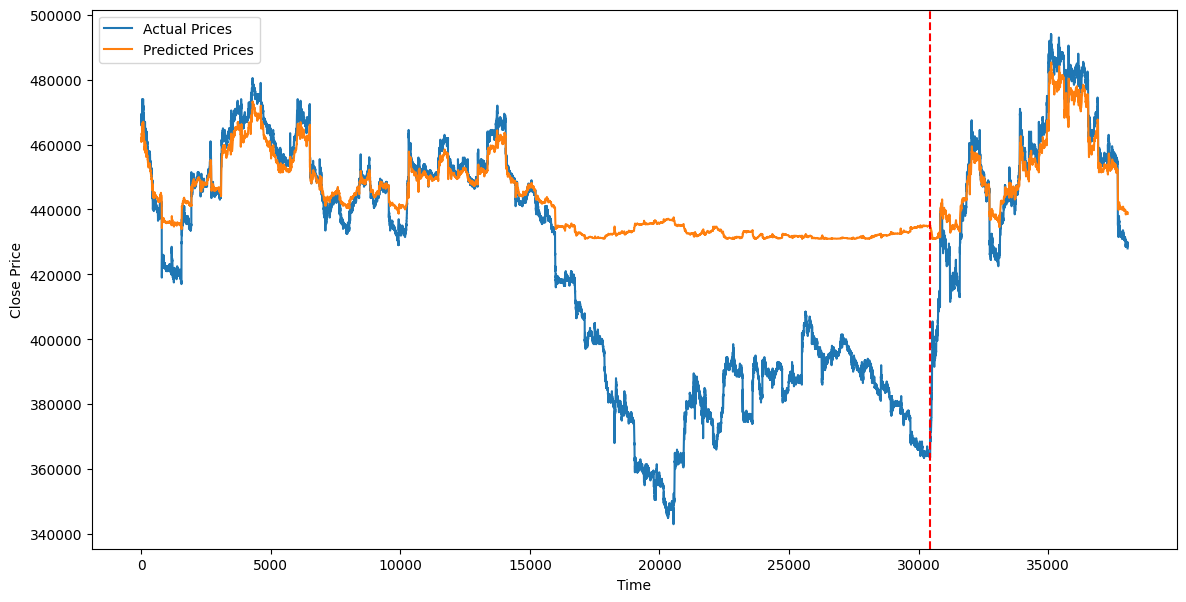

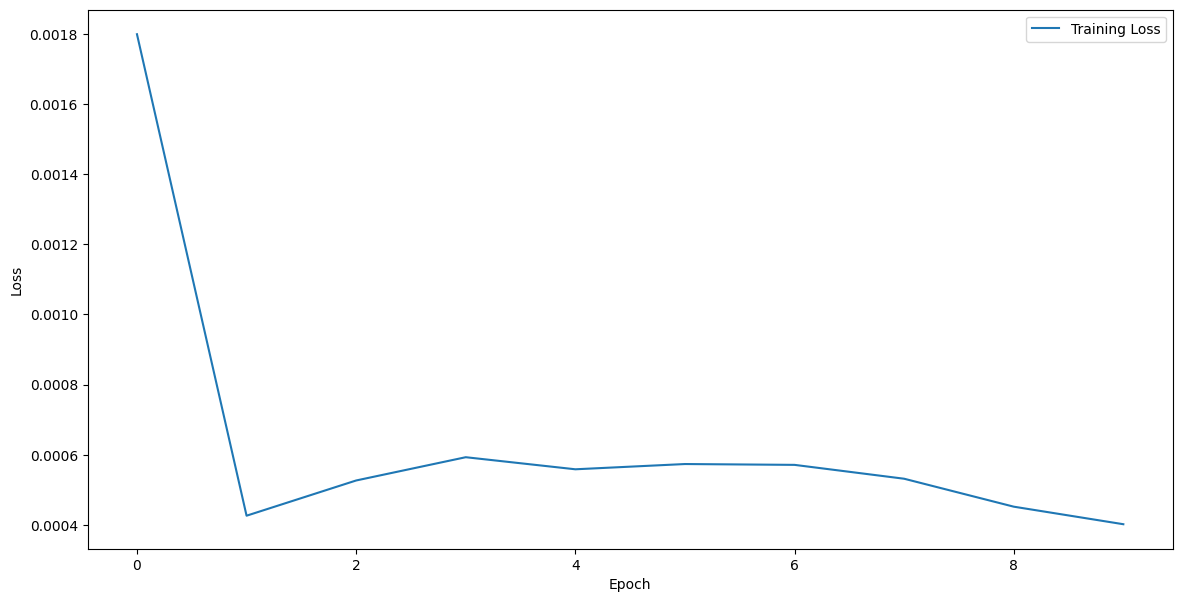

In [20]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from datetime import datetime

# Load the data
df = pd.read_json('/root/Personal/DS_DE/A006400_분봉.json')
df = df[['high', 'low', 'open', 'volume', 'close']]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Save the scaler
with open('scaler_GRU.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Define the dataset
class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
seq_length = 7
batch_size = 32
learning_rate = 0.0001
num_epochs = 10

# Prepare the dataset and dataloader
train_dataset = StockDataset(train_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = StockDataset(test_data, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the GRU model
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        output, hn = self.gru(x, h_0)
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

input_size = train_data.shape[1]  # Number of features
hidden_size = 64
num_layers = 4
num_classes = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for inputs, target in train_dataloader:
        inputs, target = inputs.to(device), target.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'GRU.pth')

print('Model and scaler saved successfully!')

# Evaluate the model
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, target in test_dataloader:
        inputs, target = inputs.to(device), target.to(device)
        outputs = model(inputs)
        test_predictions.append(outputs.item())
        test_targets.append(target.item())

# Inverse transform the predictions and targets
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_targets = np.array(test_targets).reshape(-1, 1)

# We need to reverse the scaling to get the actual prices
test_predictions_full = np.zeros((len(test_predictions), scaled_data.shape[1]))
test_predictions_full[:, -1] = test_predictions[:, 0]
test_predictions = scaler.inverse_transform(test_predictions_full)[:, -1]

test_targets_full = np.zeros((len(test_targets), scaled_data.shape[1]))
test_targets_full[:, -1] = test_targets[:, 0]
test_targets = scaler.inverse_transform(test_targets_full)[:, -1]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_targets, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.axvline(x=len(test_targets) * 0.8, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
